# Understanding the data:

- should we merge it? if so how?
- should we exclude long plays?
- should we use all players to predict?

## Merge all input files

In [56]:
import pandas as pd
from pathlib import Path
import re
import seaborn as sns
import matplotlib.pyplot as plt

data_path = Path("/Users/giulioelmi/Desktop/NFL prediction comp/nfl-big-data-bowl-2026-prediction/train")

files = sorted(data_path.glob("input_2023_w*.csv"))

dfs = []
for idx, f in enumerate(files, start=1):
    print(f"Loading file {idx} of {len(files)}")
    df = pd.read_csv(f)
    df["file_id"] = idx   # simple numeric tag, not football week
    dfs.append(df)

inputs_all = pd.concat(dfs, ignore_index=True)


Loading file 1 of 18
Loading file 2 of 18
Loading file 3 of 18
Loading file 4 of 18
Loading file 5 of 18
Loading file 6 of 18
Loading file 7 of 18
Loading file 8 of 18
Loading file 9 of 18
Loading file 10 of 18
Loading file 11 of 18
Loading file 12 of 18
Loading file 13 of 18
Loading file 14 of 18
Loading file 15 of 18
Loading file 16 of 18
Loading file 17 of 18
Loading file 18 of 18


## Merge all output files

In [4]:
files = sorted(data_path.glob("output_2023_w*.csv"))

dfs = []
for idx, f in enumerate(files, start=1):
    print(f"Loading file {idx} of {len(files)}")
    df = pd.read_csv(f)
    df["file_id"] = idx   # simple numeric tag, not football week
    dfs.append(df)

outputs_all = pd.concat(dfs, ignore_index=True)


Loading file 1 of 18
Loading file 2 of 18
Loading file 3 of 18
Loading file 4 of 18
Loading file 5 of 18
Loading file 6 of 18
Loading file 7 of 18
Loading file 8 of 18
Loading file 9 of 18
Loading file 10 of 18
Loading file 11 of 18
Loading file 12 of 18
Loading file 13 of 18
Loading file 14 of 18
Loading file 15 of 18
Loading file 16 of 18
Loading file 17 of 18
Loading file 18 of 18


# Understanding the data

In [54]:
inputs_all.head()

game_id  play_id  player_to_predict  nfl_id  frame_id play_direction  \
0  2023090700      101              False   54527         1          right   
1  2023090700      101              False   54527         2          right   
2  2023090700      101              False   54527         3          right   
3  2023090700      101              False   54527         4          right   
4  2023090700      101              False   54527         5          right   

   absolute_yardline_number player_name player_height  player_weight  ...  \
0                        42  Bryan Cook           6-1            210  ...   
1                        42  Bryan Cook           6-1            210  ...   
2                        42  Bryan Cook           6-1            210  ...   
3                        42  Bryan Cook           6-1            210  ...   
4                        42  Bryan Cook           6-1            210  ...   

       x      y     s     a     dir       o  num_frames_output  ball_land_x  \
0  52.33  36.94  0.09  0.39  322.40  238.24                 21    63.259998   
1  52.33  36.94  0.04  0.61  200.89  236.05                 21    63.259998   
2  52.33  36.93  0.12  0.73  147.55  240.60                 21    63.259998   
3  52.35  36.92  0.23  0.81  131.40  244.25                 21    63.259998   
4  52.37  36.90  0.35  0.82  123.26  244.25                 21    63.259998   

   ball_land_y  file_id  
0        -0.22        1  
1        -0.22        1  
2        -0.22        1  
3        -0.22        1  
4        -0.22        1  

[5 rows x 24 columns]

In [55]:
outputs_all.head()

game_id  play_id  nfl_id  frame_id      x      y  file_id
0  2023090700      101   46137         1  56.22  17.28        1
1  2023090700      101   46137         2  56.63  16.88        1
2  2023090700      101   46137         3  57.06  16.46        1
3  2023090700      101   46137         4  57.48  16.02        1
4  2023090700      101   46137         5  57.91  15.56        1

## how big

In [18]:
lenght_output = len(outputs_all)
lenght_input = len(inputs_all)
print(f'Output: {lenght_output:,}')
print(f'Input: {lenght_input:,}')

Output: 562,936
Input: 4,880,579


--> the input is much larger, as most of the players we don't have to predict for

--> even if we don't have to predict for these players, they can be important for context

## how many plays

In [23]:
len(inputs_all[["game_id", "play_id"]].drop_duplicates())

14108

In [39]:
len(outputs_all[["game_id", "play_id"]].drop_duplicates())

14108

--> like expected, same number of plays

## how many players

In [41]:
inputs_all["nfl_id"].nunique() 

1384

In [42]:
outputs_all["nfl_id"].nunique() 

1178

--> Almost every player in the roster needs to be predicted for at least once.

## outliers in play lenght

In [76]:
mean_inputs = inputs_all["num_frames_output"].mean()
print("mean = ",mean_inputs)
inputs_all["num_frames_output"].describe()
longest = inputs_all.loc[inputs_all["num_frames_output"].idxmax()]
print(longest)

mean =  11.641469997719533
game_id                             2023091100
play_id                                   3167
player_to_predict                         True
nfl_id                                   54650
frame_id                                     1
play_direction                            left
absolute_yardline_number                    33
player_name                  Christian Benford
player_height                              6-1
player_weight                              205
player_birth_date                   2000-09-21
player_position                             CB
player_side                            Defense
player_role                 Defensive Coverage
x                                        31.44
y                                        38.31
s                                         0.35
a                                         0.08
dir                                     113.32
o                                        41.96
num_frames_output                

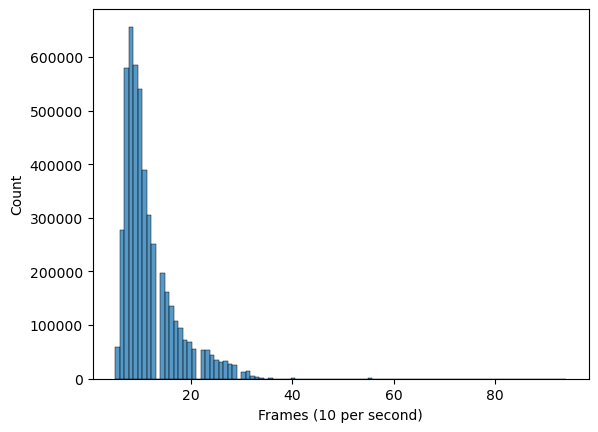

In [47]:
sns.histplot(inputs_all["num_frames_output"], bins=100)
plt.xlabel("Frames (10 per second)")
plt.ylabel("Count")
plt.show()

I was reading in the comments that some people mentioned there are some outliers in play lenght, and that they are mistakes in the data (the flagging didn't occur right)

--> the avg play lenght is 11 frames (1.1 seconds), which makes sense (how long the ball is in the air for. 

--> the max lenght is 9 seconds, impossible for a ball to fly this long
  

### Visaualization

In [81]:
from matplotlib.animation import FuncAnimation, PillowWriter
from pathlib import Path
from IPython.display import display, Image
from matplotlib import rcParams

# --------------------
# CONFIG
# --------------------
GAME_ID = 2023091100
PLAY_ID = 3167
FPS = 10  # frames per second

# --------------------
# LOAD DATA
# --------------------
# If you already have inputs_all / outputs_all DataFrames in memory, we’ll use them.
# Otherwise, we’ll try to load from CSVs named 'inputs_all.csv' and 'outputs_all.csv'.
try:
    inputs = inputs_all
    outputs = outputs_all
except NameError:
    inputs = pd.read_csv("inputs_all.csv")
    outputs = pd.read_csv("outputs_all.csv")

# Filter to the play
inp = inputs[(inputs["game_id"] == GAME_ID) & (inputs["play_id"] == PLAY_ID)].copy()
out = outputs[(outputs["game_id"] == GAME_ID) & (outputs["play_id"] == PLAY_ID)].copy()

if inp.empty:
    raise ValueError("No input frames found for that game_id/play_id.")
if out.empty:
    print("Warning: No output frames found for that game_id/play_id. We'll animate input only.")

# Sanity: do outputs have positions?
have_out_xy = set(["x", "y"]).issubset(out.columns)

# Precompute maps from input (pre-throw) rows
side_map = (
    inp.groupby("nfl_id")["player_side"]
      .agg(lambda s: s.dropna().iloc[0] if len(s.dropna()) else "Unknown")
      .to_dict()
)
role_map = (
    inp.groupby("nfl_id")["player_role"]
      .agg(lambda s: s.dropna().iloc[0] if len(s.dropna()) else "Unknown")
      .to_dict()
)
name_map = (
    inp.groupby("nfl_id")["player_name"]
      .agg(lambda s: s.dropna().iloc[0] if len(s.dropna()) else str(int(s.iloc[0])))
      .to_dict()
)

# Maximum input frames (throw happens at end of input sequence)
T_in = int(inp["frame_id"].max())

# Build unified frames table
inp_use = inp[["nfl_id", "frame_id", "x", "y", "player_side"]].copy()
inp_use["frame"] = inp_use["frame_id"]  # 1..T_in
inp_use.drop(columns=["frame_id"], inplace=True)

if not out.empty and have_out_xy:
    out_use = out[["nfl_id", "frame_id", "x", "y"]].copy()
    out_use["frame"] = T_in + out_use["frame_id"]  # continue timeline
    out_use.drop(columns=["frame_id"], inplace=True)
    frames_all = pd.concat([inp_use[["nfl_id","frame","x","y"]], out_use], ignore_index=True)
else:
    frames_all = inp_use[["nfl_id","frame","x","y"]].copy()

# Timeline length
T = int(frames_all["frame"].max())

# ---------------
# BALL TRAJECTORY
# ---------------
# Passer (from roles in input)
passers = inp[inp["player_role"] == "Passer"]["nfl_id"].unique()
if len(passers) == 0:
    off_ids_tmp = inp[inp["player_side"] == "Offense"]["nfl_id"].unique()
    passer_id = off_ids_tmp[0] if len(off_ids_tmp) else int(inp["nfl_id"].iloc[0])
else:
    passer_id = passers[0]

# Passer location at throw frame (end of input)
passer_throw_row = inp[(inp["nfl_id"] == passer_id) & (inp["frame_id"] == T_in)]
if passer_throw_row.empty:
    tmp = inp[inp["nfl_id"] == passer_id].sort_values("frame_id")
    passer_x0 = float(tmp.iloc[-1]["x"])
    passer_y0 = float(tmp.iloc[-1]["y"])
else:
    passer_x0 = float(passer_throw_row["x"].iloc[0])
    passer_y0 = float(passer_throw_row["y"].iloc[0])

# Ball landing point (from input columns)
land_x_vals = inp["ball_land_x"].dropna().unique()
land_y_vals = inp["ball_land_y"].dropna().unique()
has_land = (len(land_x_vals) > 0) and (len(land_y_vals) > 0)

if has_land:
    land_x = float(land_x_vals[0])
    land_y = float(land_y_vals[0])
else:
    land_x, land_y = passer_x0, passer_y0

# Ball XY over frames:
# - 1..T_in: sits with passer
# - T_in+1..T: linear interpolation to (land_x, land_y)
ball_xy = np.zeros((T, 2), dtype=float)
ball_xy[:T_in, 0] = passer_x0
ball_xy[:T_in, 1] = passer_y0
if T > T_in and has_land:
    N = T - T_in
    ball_xy[T_in:, 0] = np.linspace(passer_x0, land_x, N, endpoint=True)
    ball_xy[T_in:, 1] = np.linspace(passer_y0, land_y, N, endpoint=True)
else:
    ball_xy[T_in:, 0] = passer_x0
    ball_xy[T_in:, 1] = passer_y0

# ----------------
# DRAW THE FIELD
# ----------------
def draw_field(ax):
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 53.3)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xticks(range(0, 121, 10))
    ax.set_yticks([0, 13.325, 26.65, 40.0, 53.3])
    ax.grid(False)
    # sidelines
    ax.plot([0,120],[0,0], lw=2, color='black')
    ax.plot([0,120],[53.3,53.3], lw=2, color='black')
    # end lines
    ax.plot([0,0],[0,53.3], lw=2, color='black')
    ax.plot([120,120],[0,53.3], lw=2, color='black')
    # yard lines every 10 yds
    for yd in range(10, 120, 10):
        ax.plot([yd, yd], [0,53.3], lw=0.75, color='lightgray', linestyle='-')
    ax.set_xlabel("X (yards)")
    ax.set_ylabel("Y (yards)")
    ax.set_title(f"Game {GAME_ID}, Play {PLAY_ID}", fontsize=12, pad=10)

# ----------------
# PREP ARTISTS
# ----------------
fig, ax = plt.subplots(figsize=(12, 6))
draw_field(ax)

off_scatter = ax.scatter([], [], s=60, marker='o', label='Offense')   # auto color cycle
def_scatter = ax.scatter([], [], s=60, marker='s', label='Defense')
ball_plot, = ax.plot([], [], marker='o', markersize=10, lw=0, label='Ball')

txt = ax.text(0.5, 1.02, "", transform=ax.transAxes, ha='center', va='bottom', fontsize=11)
ax.legend(loc="upper right")

# offense/defense sets
off_ids = {pid for pid, side in side_map.items() if str(side).lower().startswith('offense')}
def_ids = {pid for pid, side in side_map.items() if str(side).lower().startswith('defense')}

# group frames for fast lookup
by_frame = {f: df for f, df in frames_all.groupby("frame")}

def init():
    off_scatter.set_offsets(np.empty((0,2)))
    def_scatter.set_offsets(np.empty((0,2)))
    ball_plot.set_data([], [])
    txt.set_text("")
    return off_scatter, def_scatter, ball_plot, txt

def update(f):
    df = by_frame.get(f, None)
    if df is None:
        return off_scatter, def_scatter, ball_plot, txt

    # split by team
    df_off = df[df["nfl_id"].isin(off_ids)]
    df_def = df[df["nfl_id"].isin(def_ids)]

    # scatter positions
    off_scatter.set_offsets(df_off[["x","y"]].values if not df_off.empty else np.empty((0,2)))
    def_scatter.set_offsets(df_def[["x","y"]].values if not df_def.empty else np.empty((0,2)))

    # ball
    bx, by = ball_xy[f-1, 0], ball_xy[f-1, 1]
    ball_plot.set_data([bx], [by])

    phase = "Pre-throw" if f <= T_in else "Post-throw"
    txt.set_text(f"Frame {f}/{T}  •  {phase}")

    return off_scatter, def_scatter, ball_plot, txt

anim = FuncAnimation(
    fig, update, frames=np.arange(1, T+1), init_func=init,
    interval=1000//FPS, blit=False
)

# ----------------
# INLINE DISPLAY + SAVE GIF
# ----------------
# 1) Inline animation (JS/HTML player)
rcParams["animation.html"] = "jshtml"
display(anim)